# Previsão de jogos de Counter Strike

## Objetivo

Neste projeto, iremos treinar dois modelos, uma rede neural e um classificador de árvore aleatória, para prever o resultado de partidas do jogo Counter Strike Global Offensive. Os dados foram _web-scrapped_ de um site chamado [HLTV](https://www.hltv.org), que nos dá os resultados de partidas profissionais, junto com estatísticas relevantes de cada jogador.

Para isso, precisamos descobrir quais estatísticas devemos incluir por jogador, bem como o número de dias para qual consideraremos o tempo para a performance de cada um. 

## Metodologia 

A ideia para previsão é de colher as médias temporais de cada uma das estatísticas para cada jogador, e utilizar isso para tentar prever partidas futuras. Portanto, para cada partida, acumulamos os resultados de cada estatística para todos os resultados passados de cada jogador, e utilizamos isso para prever os resultados.

Para isso, escrevemos um pequeno programa em Rust que acumula os dados e organiza-os em um csv. Cada linha contém todas as estatísticas de cada jogador do time 1, concatenadas com todas as estatísticas de cada jogador do time 2, seguidas do resultado (0 para vitória do time 1 e 1 para vitória do time 2).


## Correlação dos dados

Tentaremos, primeiro, determinar quais campos são relevantes. Para cada jogador, temos os seguintes dados por mapa jogado.

1. Número de abates
2. Número de assisténcias
3. Número de mortes
4. Número de abates que foram por tiro na cabeça
5. KAST (Kill, Assist, Survival, Traded) - porcentagem de rounds que o jogador abateu alguém, conseguiu uma assistência, sobreviveu ou foi trocado (morreu mas o inimigo foi morto logo em seguida por algum jogador do time).
6. _First kill difference_ - quantas vezes o jogador pegou o primeiro abate subtraido quantas vezes o jogador foi o primeiro a morrer
7. Dano médio por round
8. HLTV Rating 2.0 - pontuação calculada pelo próprio HLTV, cujo algoritmo não é divulgado, mas que considera todas as estatísticas anteriores, e mais algumas não explicitadas. É uma pontuação que tenta avaliar diretamente a performance de um jogador, tendo como média o valor 1.0. 

Para isso, começamos determinando a correlação entre os dados, e concatenando as informações de cada jogador _row wise_. Depois, usamos o pandas para calcular a correlação de cada campo com a vitória.

In [1]:
%matplotlib inline
import numpy as np
from csv import reader
from pandas import DataFrame

all_fields = []
campos = ['Abates', 'Assistências', 'Mortes', 'Tiros na Cabeça', 'KAST', 'FKDiff', 'ADR', 'Rating', 'Vitória']
with open('generated-data/all-fields.csv') as f:
    csv = reader(f, delimiter=',')
    for row in csv:
        for i in range(10):
            fields = row[8*i:8*(i+1)]
            winner_team = row[-1] # 0 for team 1, 1 for team 2
            if i < 5:
                won = 1.0 if winner_team == "0" else 0.0
            else:
                won = 1.0 if winner_team == "1" else 0.0
            all_fields.append(fields + [won])
            
dataset = DataFrame(all_fields, columns=campos)
player_corr = dataset.corr()
player_corr.Vitória.sort_values(ascending=False)

Vitória            1.000000
KAST               0.210676
Rating             0.200908
ADR                0.132295
Abates             0.107173
FKDiff             0.104344
Assistências       0.066728
Tiros na Cabeça    0.062313
Mortes            -0.159766
Name: Vitória, dtype: float64

Segundo a matriz de correlação, a estatística que melhor correlaciona com a vitória do jogador numa partida é a média temporal do seu HLTV Rating. Isso é esperado, já que o próprio rating tem alta relação com todas as outras variáveis (como ADR e KAST) e utiliza-as no seu cálculo:

In [2]:
player_corr.Rating.sort_values(ascending=False)

Rating             1.000000
ADR                0.878460
KAST               0.805088
Abates             0.729488
FKDiff             0.592266
Tiros na Cabeça    0.461733
Vitória            0.200908
Assistências       0.184111
Mortes            -0.509393
Name: Rating, dtype: float64

Podemos fazer a mesma análise, mas para a média das estatísticas do time de cada jogador, e estudar a correlação dessas médias com a vitória do time:

In [3]:
all_fields_team = []
campos = ['Abates', 'Assistências', 'Mortes', 'Tiros na Cabeça', 'KAST', 'FKDiff', 'ADR', 'Rating', 'Vitória']
with open('generated-data/all-fields.csv') as f:
    csv = reader(f, delimiter=',')
    for row in csv:
        for team in range(2):
            player_stats = [row[40*team + player*8: 40*team+(player + 1)*8] for player in range(5)]
            average = [sum(map(float, x))/5 for x in zip(*player_stats)]
            won = team == int(row[-1])
            all_fields_team.append(average + [won])

dataset = DataFrame(all_fields_team, columns=campos)
team_corr = dataset.corr()
team_corr.Vitória.sort_values(ascending=False)

Vitória            1.000000
Rating             0.271144
KAST               0.257011
ADR                0.254884
FKDiff             0.203674
Abates             0.160975
Tiros na Cabeça    0.124926
Assistências       0.107955
Mortes            -0.175039
Name: Vitória, dtype: float64

Podemos também, visualizar a matriz inteira como um heatmap:

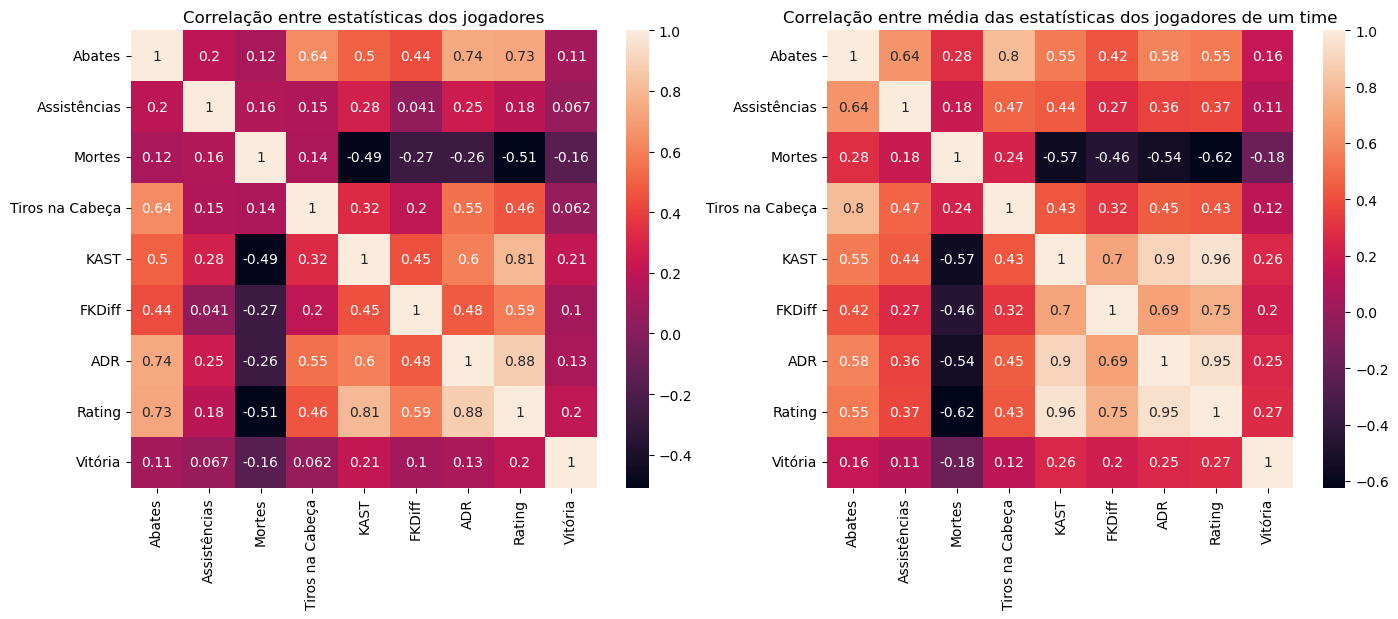

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(player_corr, ax=ax1, annot=True)
ax1.set_title('Correlação entre estatísticas dos jogadores')
sns.heatmap(team_corr, ax=ax2, annot=True)
ax2.set_title('Correlação entre média das estatísticas dos jogadores de um time')
plt.tight_layout(pad=0)
plt.savefig('relatorio/correlacoes.png')

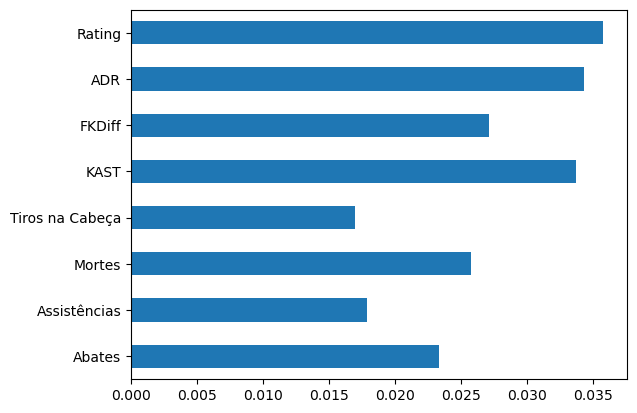

In [5]:
from pandas import Series
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

data = np.array(list(map(lambda l: list(map(float, l)), all_fields_team)))
data = data[~(np.isnan(data).any(axis=1))]
importances = mutual_info_classif(data[:, :-1], data[:, -1])

Series(importances, campos[:-1]).plot(kind='barh')
plt.savefig('relatorio/information.png', bbox_inches="tight")
plt.show()

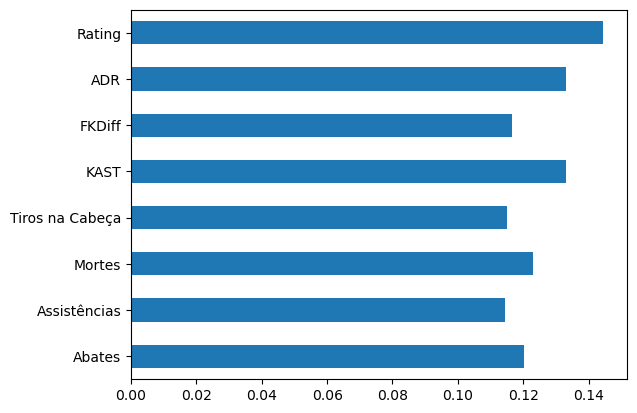

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=30)
model.fit(data[:, :-1], data[:, -1])
importances = model.feature_importances_

Series(importances, campos[:-1]).plot(kind='barh')
plt.savefig('relatorio/random-forest-importancias.png', bbox_inches="tight")
plt.show()

## Treinando modelos

Primeiro, importamos as funções relevantes e definimos uma função para dividir os dados de treino dos dados de validação:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [8]:
def get_data(path, filter_nan=True):
    return train_test_split(x, y, test_size=0.10)

In [9]:
def accuracy(path):
    data = np.genfromtxt(path, delimiter=',')
    X_train, X_test, y_train, rfc_true = train_test_split(data[:, :-1], data[:, -1], test_size=0.10)
    rfc = RandomForestClassifier(max_depth=30)
    rfc.fit(X_train, y_train)
    rfc_predicted = rfc.predict(X_test)
    
    data_without_nan = data[~(np.isnan(data).any(axis=1))]
    
    X_train, X_test, y_train, lr_true = train_test_split(data_without_nan[:, :-1], data_without_nan[:, -1], test_size=0.10)
    lr = LogisticRegression(max_iter=2000)
    lr.fit(X_train, y_train)
    lr_predicted = lr.predict(X_test)
    return ((rfc_predicted, rfc_true), (lr_predicted, lr_true))

def print_stats(matrix):
    [[true_neg, false_neg], [false_pos, true_pos]] = confusion_matrix(*matrix)
    total = true_neg + false_neg + false_pos + true_pos
    print(f"Acurácia: {100 * (true_pos + true_neg) / total:.2f}")
    print(f"Sensibilidade: {100 * true_pos / (true_pos + false_neg):.2f}")
    print(f"Especificidade: {100 * true_neg / (true_neg + false_pos):.2f}")
    print(f"Precisão: {100 * true_pos / (true_pos + false_pos):.2f}")

def show_accuracy(path):
    rfc, lr = accuracy(path)
    print_stats(rfc)
    print_stats(lr)

In [10]:
show_accuracy('generated-data/all-fields.csv')

Acurácia: 66.07
Sensibilidade: 56.23
Especificidade: 74.82
Precisão: 66.51
Acurácia: 66.38
Sensibilidade: 59.77
Especificidade: 72.42
Precisão: 66.45


In [11]:
show_accuracy('generated-data/deaths-fkdiff-rating.csv')

Acurácia: 66.30
Sensibilidade: 55.29
Especificidade: 75.74
Precisão: 66.14
Acurácia: 65.51
Sensibilidade: 57.96
Especificidade: 72.32
Precisão: 65.40


In [12]:
show_accuracy('generated-data/deaths-fkdiff-kast.csv')

Acurácia: 63.54
Sensibilidade: 52.79
Especificidade: 72.73
Precisão: 62.37
Acurácia: 65.14
Sensibilidade: 57.07
Especificidade: 71.82
Precisão: 62.64


In [13]:
show_accuracy('generated-data/deaths-fkdiff-adr.csv')

Acurácia: 64.79
Sensibilidade: 54.76
Especificidade: 73.51
Precisão: 64.28
Acurácia: 65.97
Sensibilidade: 57.44
Especificidade: 73.26
Precisão: 64.77


In [14]:
show_accuracy('generated-data/just-rating.csv')

Acurácia: 60.17
Sensibilidade: 49.96
Especificidade: 68.65
Precisão: 56.99
Acurácia: 61.62
Sensibilidade: 42.37
Especificidade: 77.17
Precisão: 60.00


In [17]:
show_accuracy('generated-data/just-kast.csv')

Acurácia: 63.20
Sensibilidade: 54.85
Especificidade: 70.44
Precisão: 61.69
Acurácia: 66.51
Sensibilidade: 58.37
Especificidade: 73.49
Precisão: 65.37


In [18]:
show_accuracy('generated-data/just-adr.csv')

Acurácia: 62.63
Sensibilidade: 51.52
Especificidade: 73.09
Precisão: 64.33
Acurácia: 64.09
Sensibilidade: 55.03
Especificidade: 71.64
Precisão: 61.81


In [15]:
show_accuracy('generated-data/deaths-kast-adr-rating.csv')

Acurácia: 63.69
Sensibilidade: 56.48
Especificidade: 70.17
Precisão: 62.98
Acurácia: 65.14
Sensibilidade: 58.46
Especificidade: 70.77
Precisão: 62.73


In [16]:
show_accuracy('generated-data/kills-deaths-assists.csv')

Acurácia: 65.66
Sensibilidade: 56.16
Especificidade: 73.87
Precisão: 65.03
Acurácia: 66.97
Sensibilidade: 57.63
Especificidade: 75.28
Precisão: 67.46
